In [1]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from torch.nn import functional as F
import torch.optim as optim
import tensorboard
import matplotlib.pyplot as plt
import matplotlib

In [2]:
dataset = torch.tensor(np.load('../../convlstm/splits/dataset.npy'))

In [3]:
dataset_norm = torch.tensor(np.load('../../convlstm/splits/dataset_normalized.npy'))

In [4]:
dataset_norm = dataset_norm.permute((0,2,1,3,4))

In [5]:
dataset = dataset.permute((0,2,1,3,4))

In [6]:
X = dataset_norm[:,:,:11,:,:]

In [7]:
y = dataset_norm[:,:,11:,:,:]

In [8]:
y_un = dataset[:,:,11:,:,:]

In [9]:
class ResBlock(nn.Module):
  def __init__(self, n_chans=8):
    super(ResBlock, self).__init__()
    self.conv = nn.Conv3d(in_channels=n_chans, out_channels=n_chans,
                          kernel_size=(3,3,3), padding='same')
    self.batch_norm = nn.BatchNorm3d(num_features=n_chans)
    torch.nn.init.kaiming_normal_(self.conv.weight, nonlinearity='relu')
    torch.nn.init.constant_(self.batch_norm.weight, 0.5)
    torch.nn.init.zeros_(self.batch_norm.bias)

  def forward(self, x):
    out = self.conv(x)
    out = self.batch_norm(out)
    out = torch.relu(out)
    return out + x

In [10]:
def base_model(n_chans=8, n_hidden=16, n_blocks=5):
  return nn.Sequential(
    nn.Conv3d(in_channels=n_chans, out_channels=n_hidden, kernel_size=(3,3,3), padding='same'),
    nn.ReLU(),
    *(n_blocks * [ResBlock(n_chans=n_hidden)]),
    nn.Conv3d(in_channels=n_hidden, out_channels=n_chans, kernel_size=(3,3,3), padding='same')
    )

In [11]:
class TheModel(nn.Module):

  def __init__(self, n_chans=8, n_hidden=16, n_blocks=5):
    super(TheModel, self).__init__()

    self.model1 = base_model(n_chans, n_hidden, n_blocks)
    self.model2 = base_model(n_chans, n_hidden, n_blocks)
    self.model3 = base_model(n_chans, n_hidden, n_blocks)

  def forward(self, x):
    y = self.model1(x)
    z = self.model2(y)
    w = self.model3(z)

    out = [y,z,w]

    return torch.cat(out, dim=2)[:,:,:30,:,:]

In [12]:
model = TheModel()

In [13]:
model.load_state_dict(torch.load('../saved_models/lr_0.0001/epoch_10000.pt', map_location=torch.device('cpu')))

<All keys matched successfully>

In [14]:
test_len = int(len(X) * 0.2)

In [15]:
test_len

162

In [16]:
ds_len = len(X)

In [17]:
ds_len

813

In [18]:
the_range = list(range(ds_len - test_len, ds_len))

In [19]:
np.random.seed(42)

In [20]:
sample_indices = np.random.choice(the_range, size=20, replace=False)

In [21]:
sample_indices

array([809, 760, 782, 706, 745, 680, 752, 702, 751, 795, 670, 735, 666,
       717, 675, 681, 794, 755, 749, 667])

In [22]:
sample = X[sample_indices,:,:,:,:]

In [23]:
y_pred = model(sample).detach().numpy()

In [24]:
y_pred.shape

(20, 8, 30, 10, 20)

In [25]:
y_true = y[sample_indices,:,:,:,:].numpy()

In [26]:
y_true.shape

(20, 8, 30, 10, 20)

In [27]:
for_mask = y_un[sample_indices,:,:,:,:]

In [28]:
y_pred = np.ma.masked_where(for_mask.isnan(), y_pred)

In [29]:
y_true = np.ma.masked_where(for_mask.isnan(), y_true)

In [30]:
cmap = plt.get_cmap('Blues')

In [31]:
cmap.set_bad(color='green')

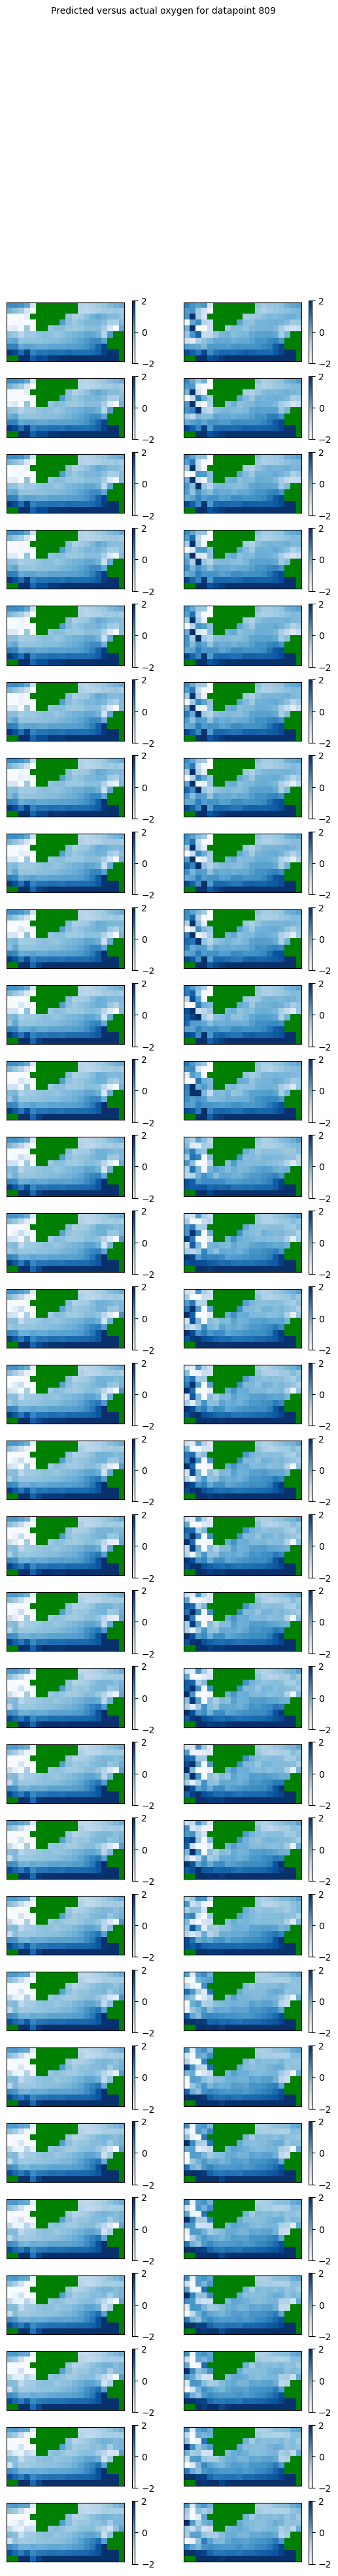

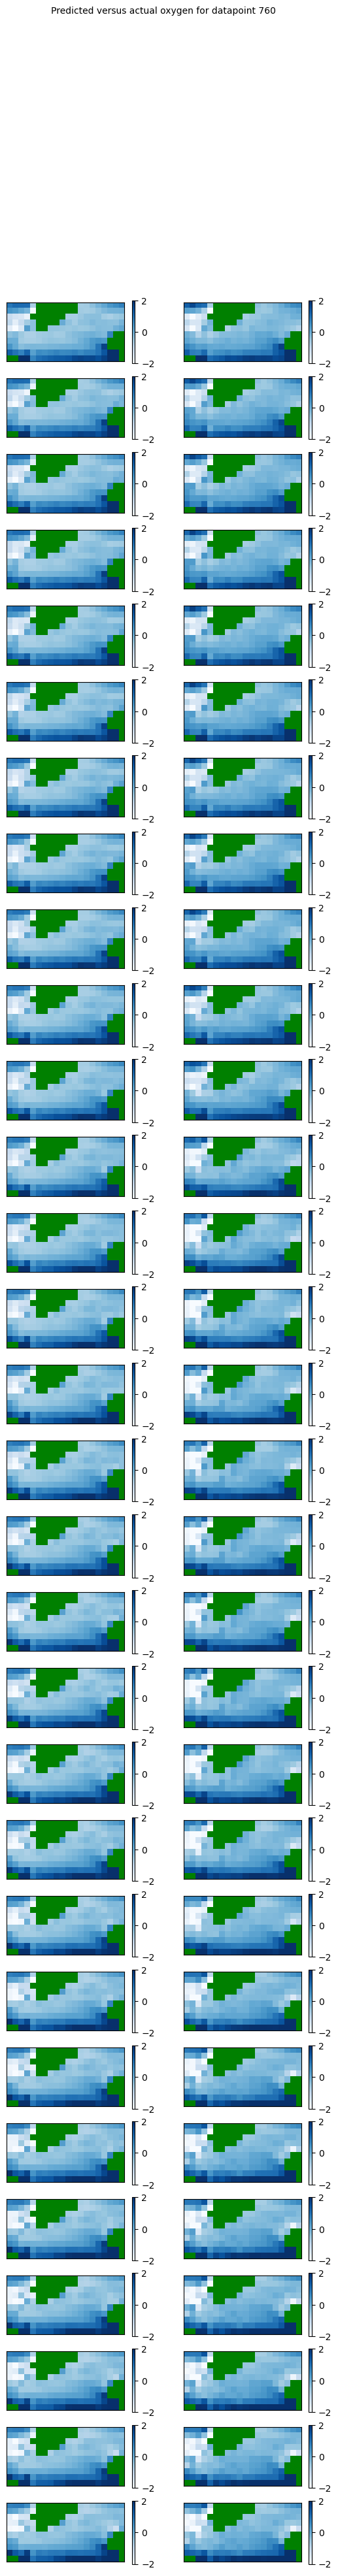

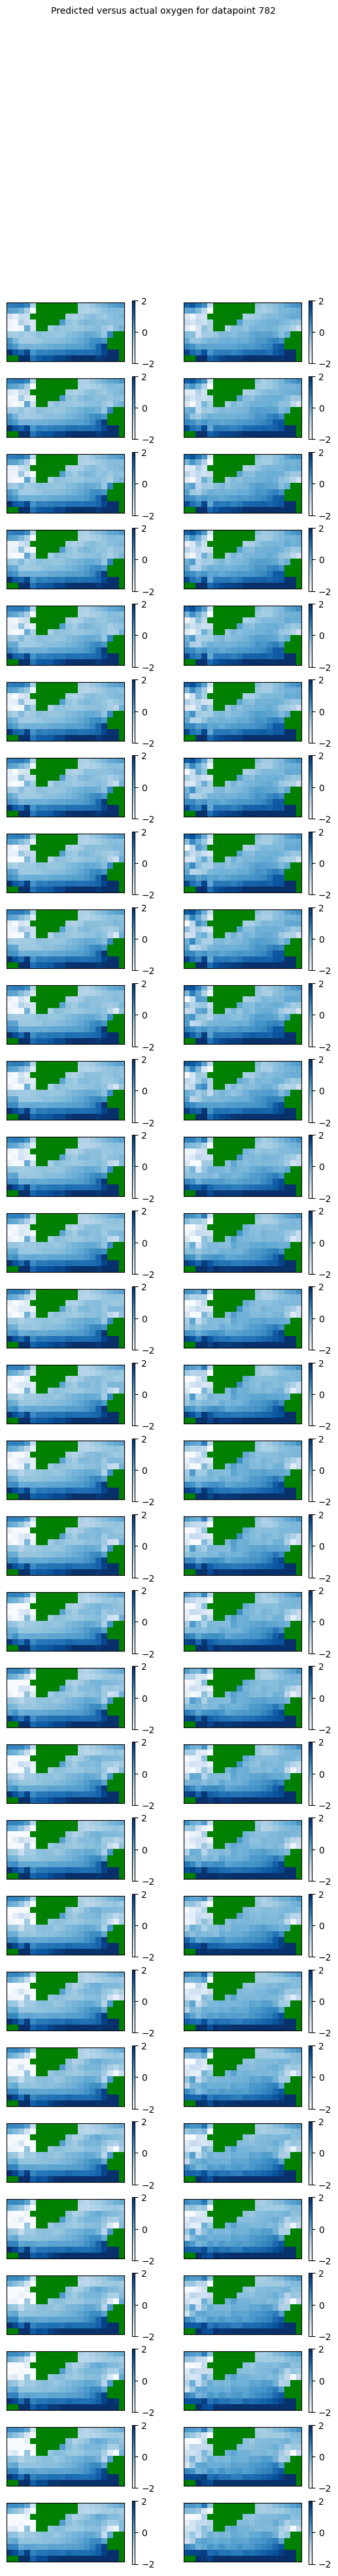

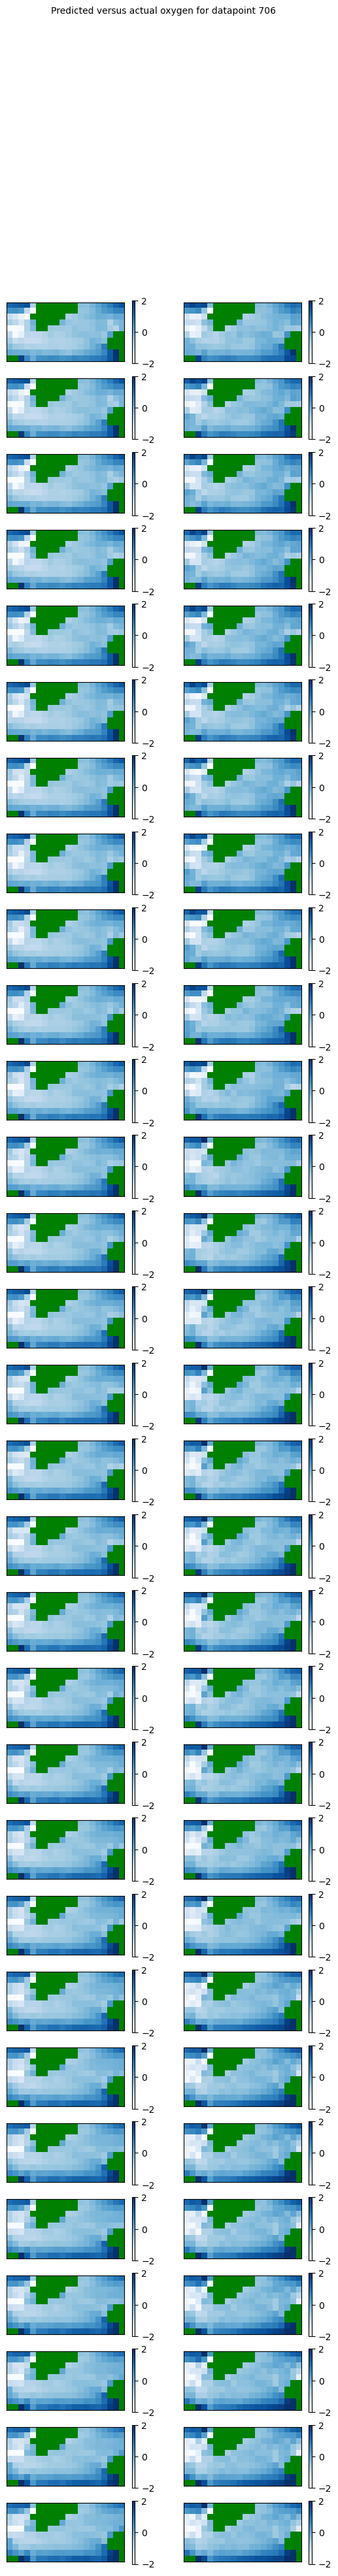

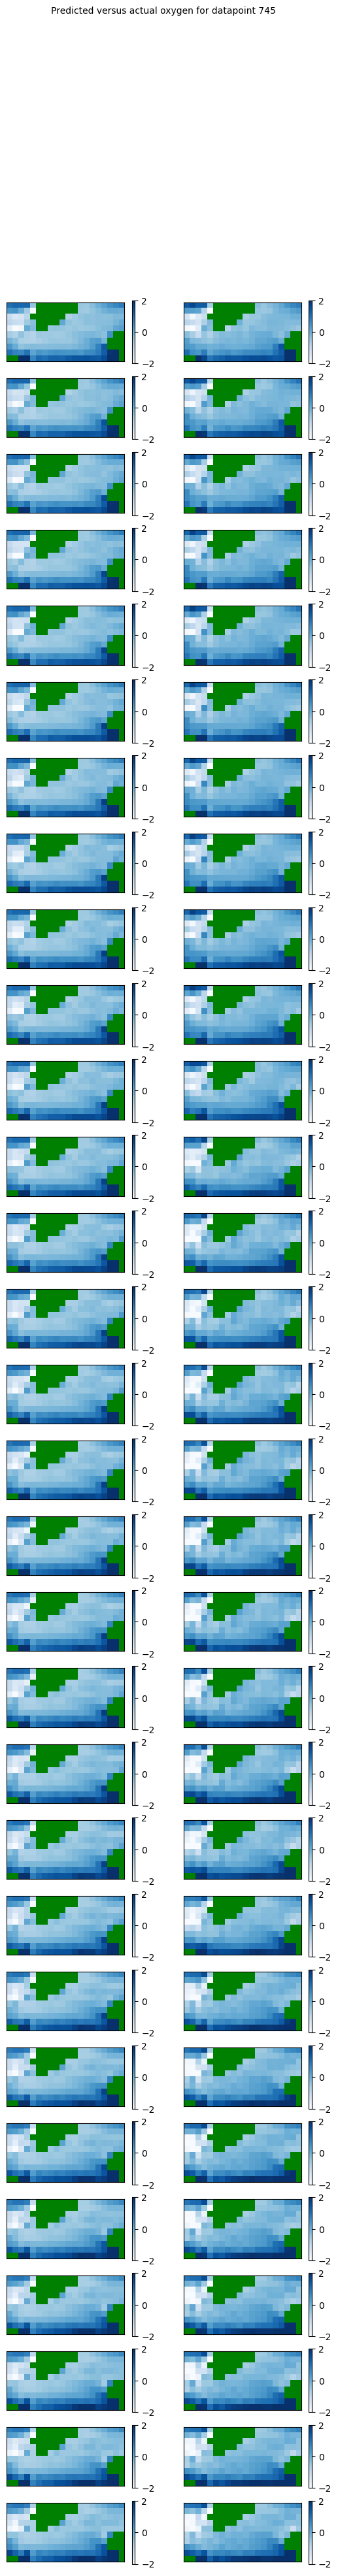

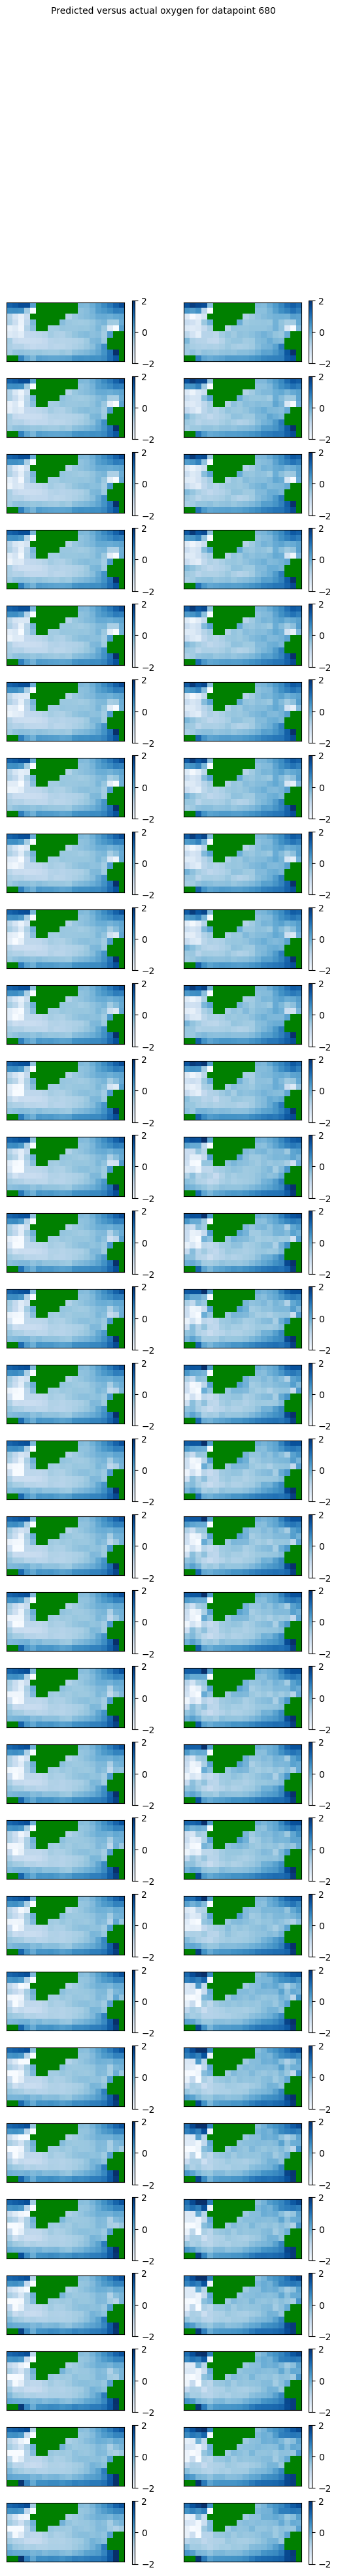

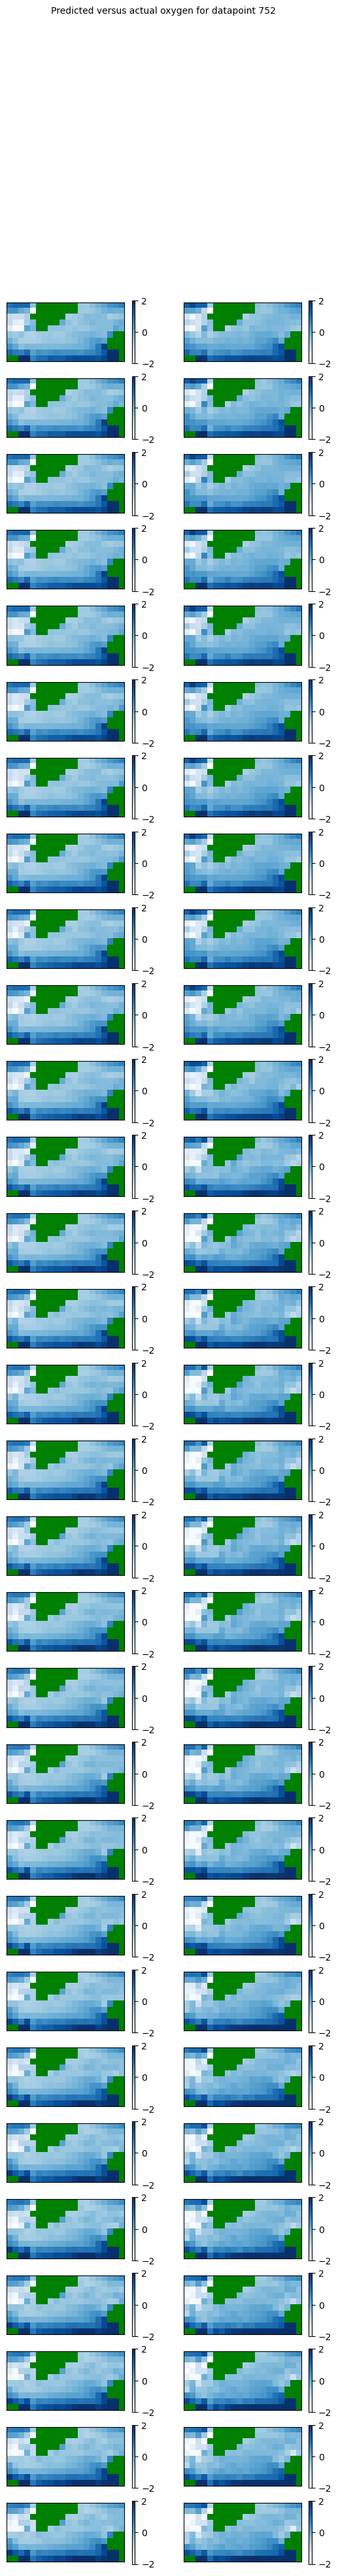

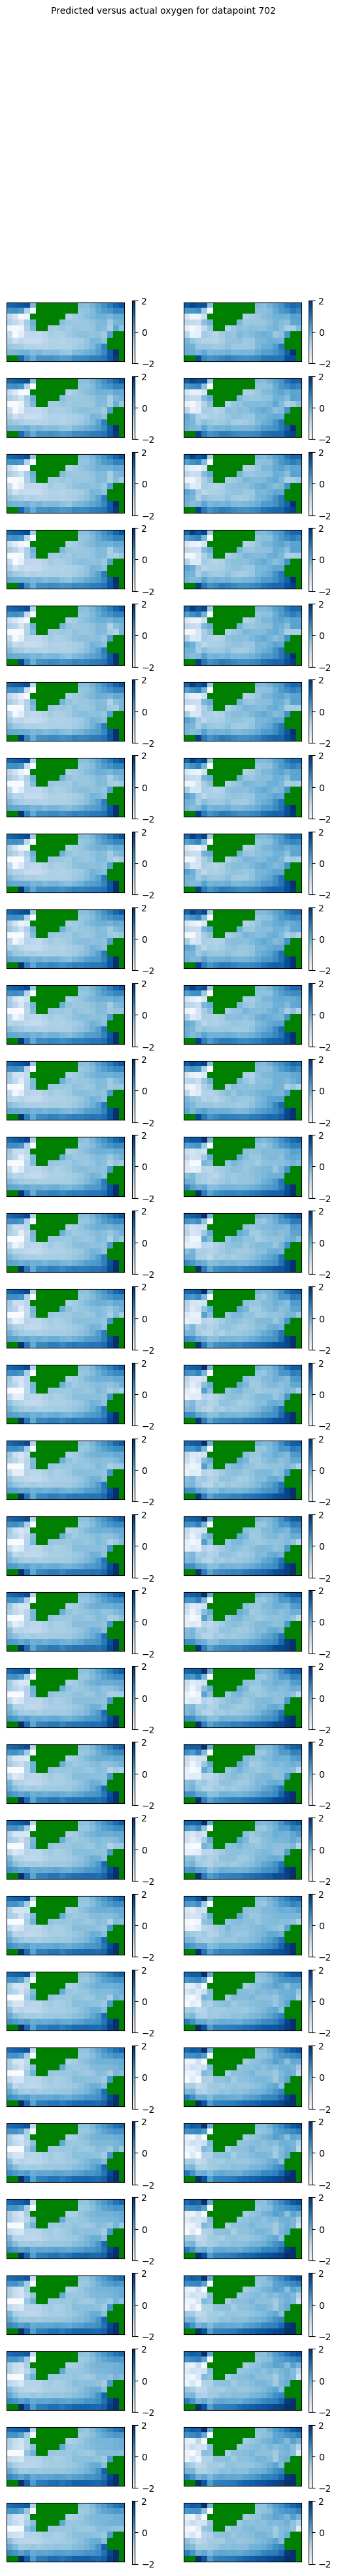

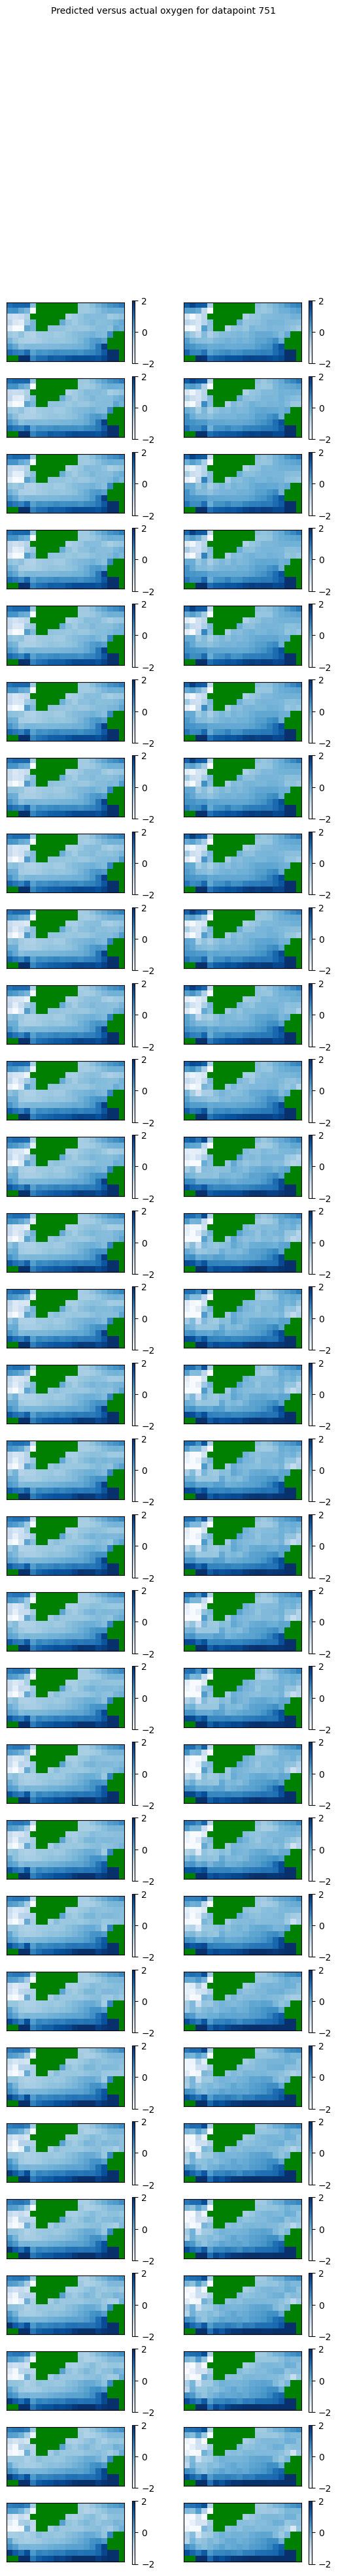

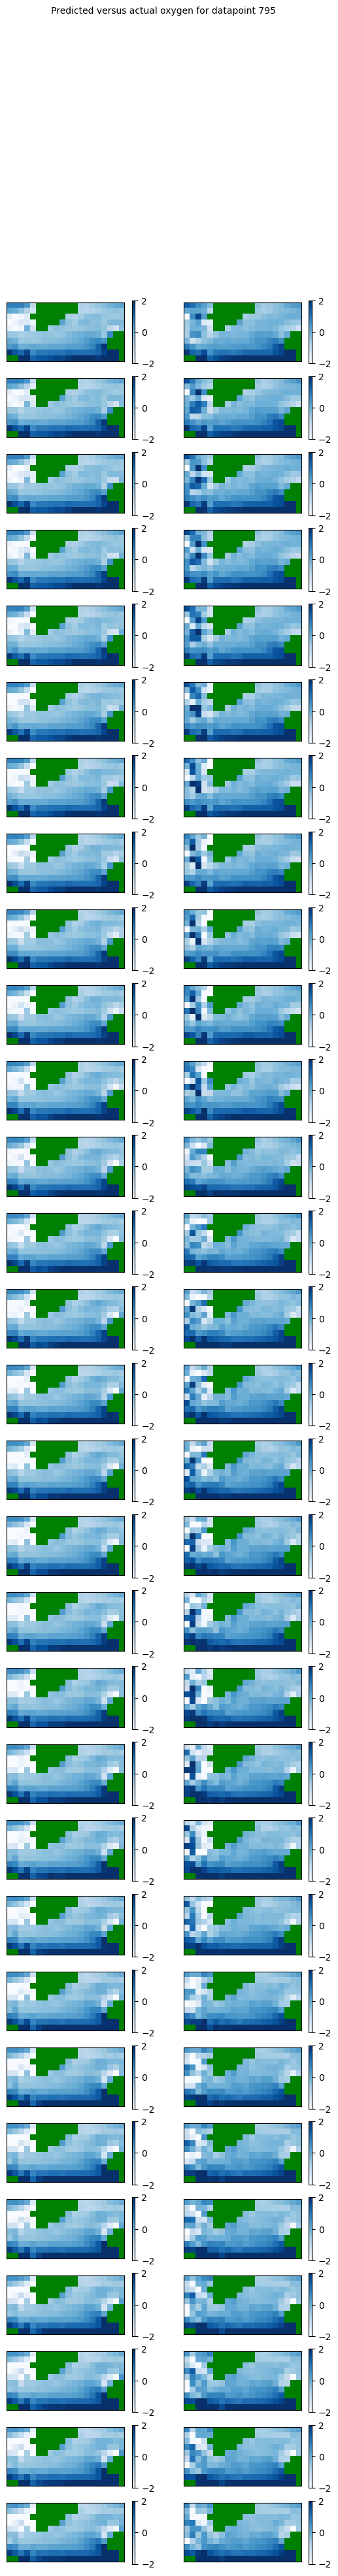

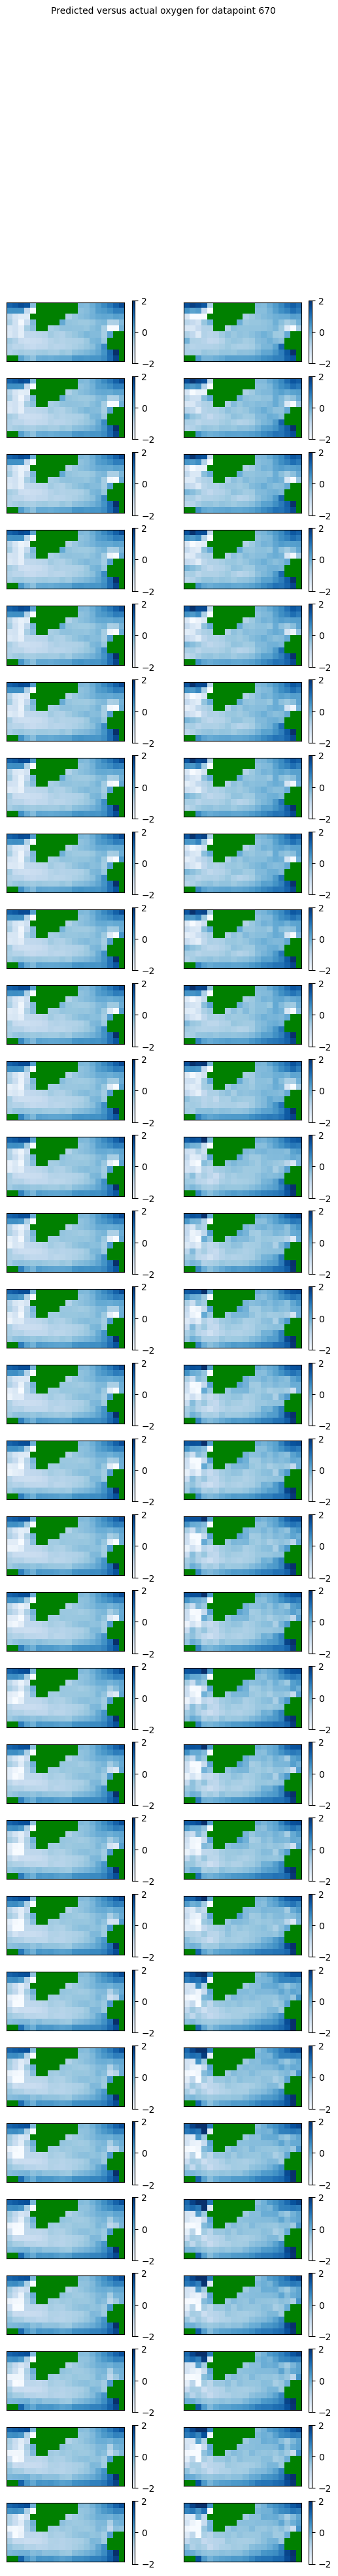

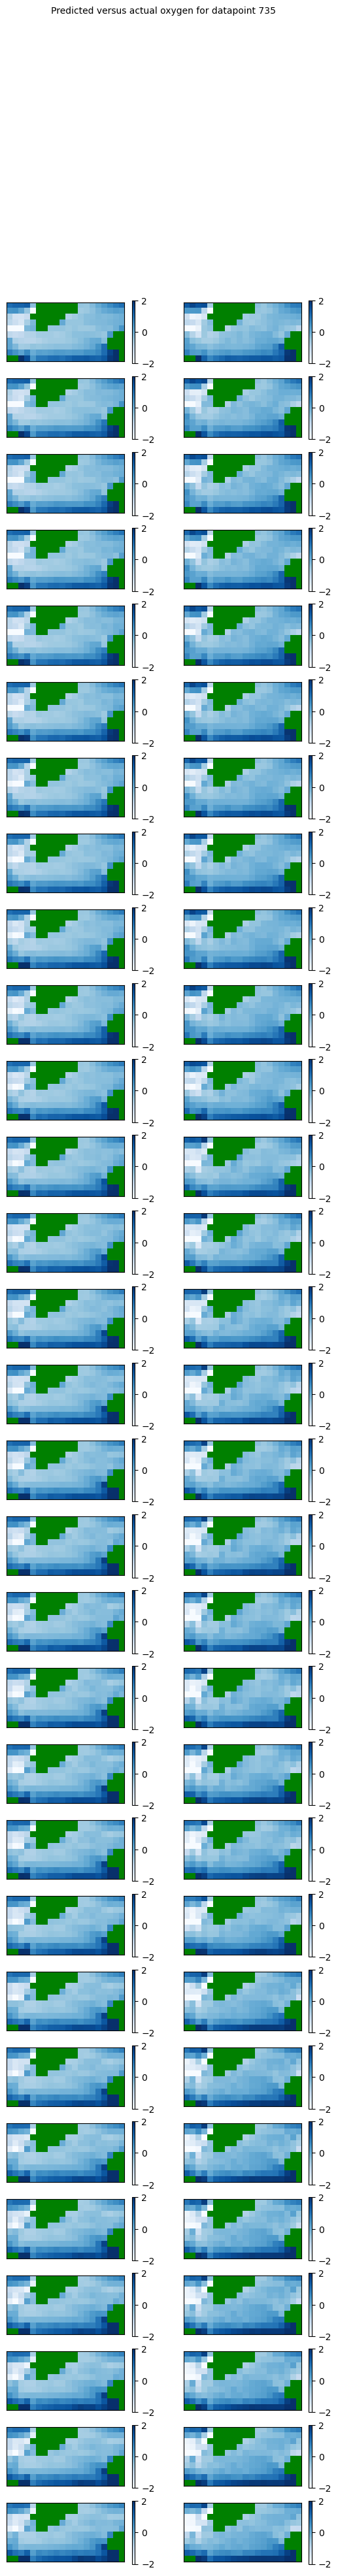

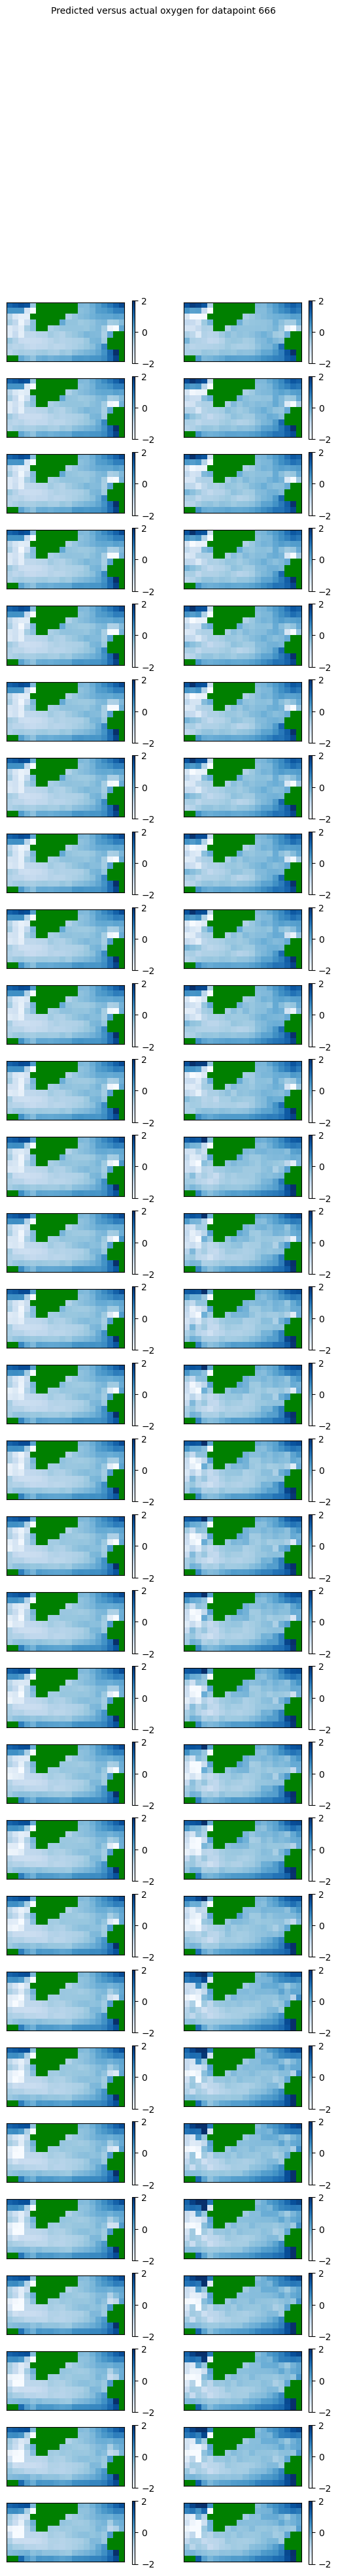

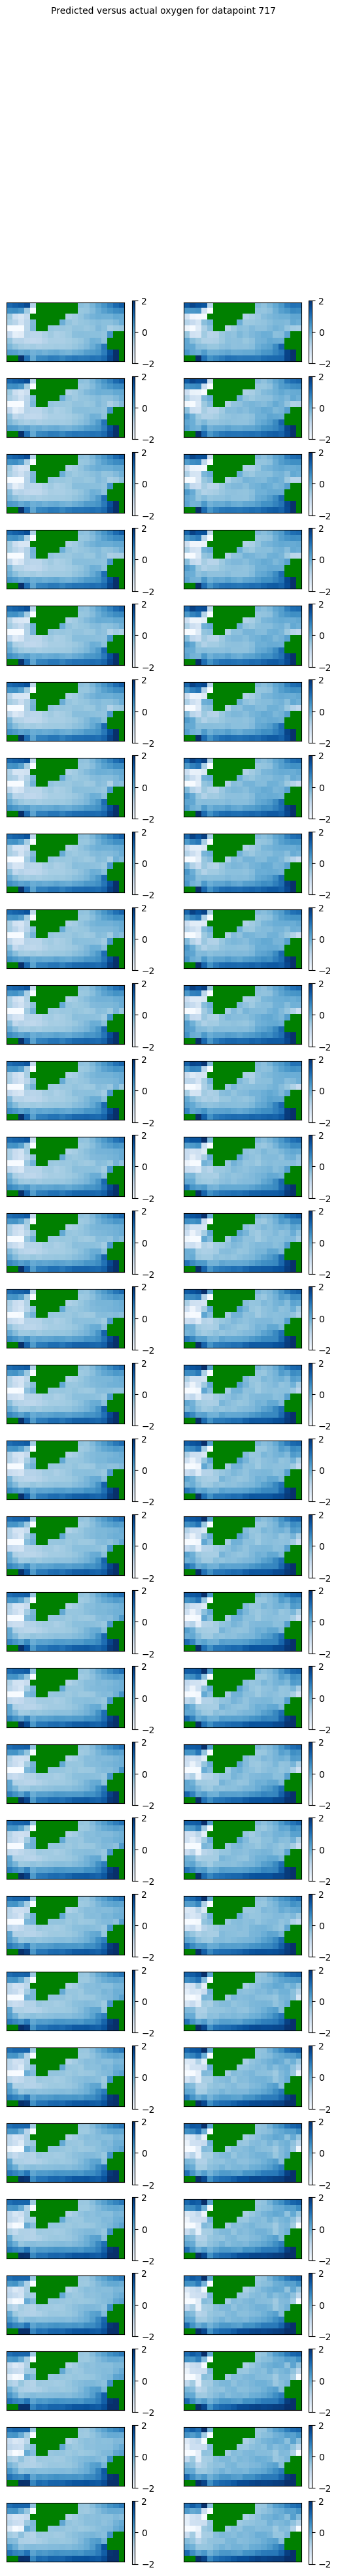

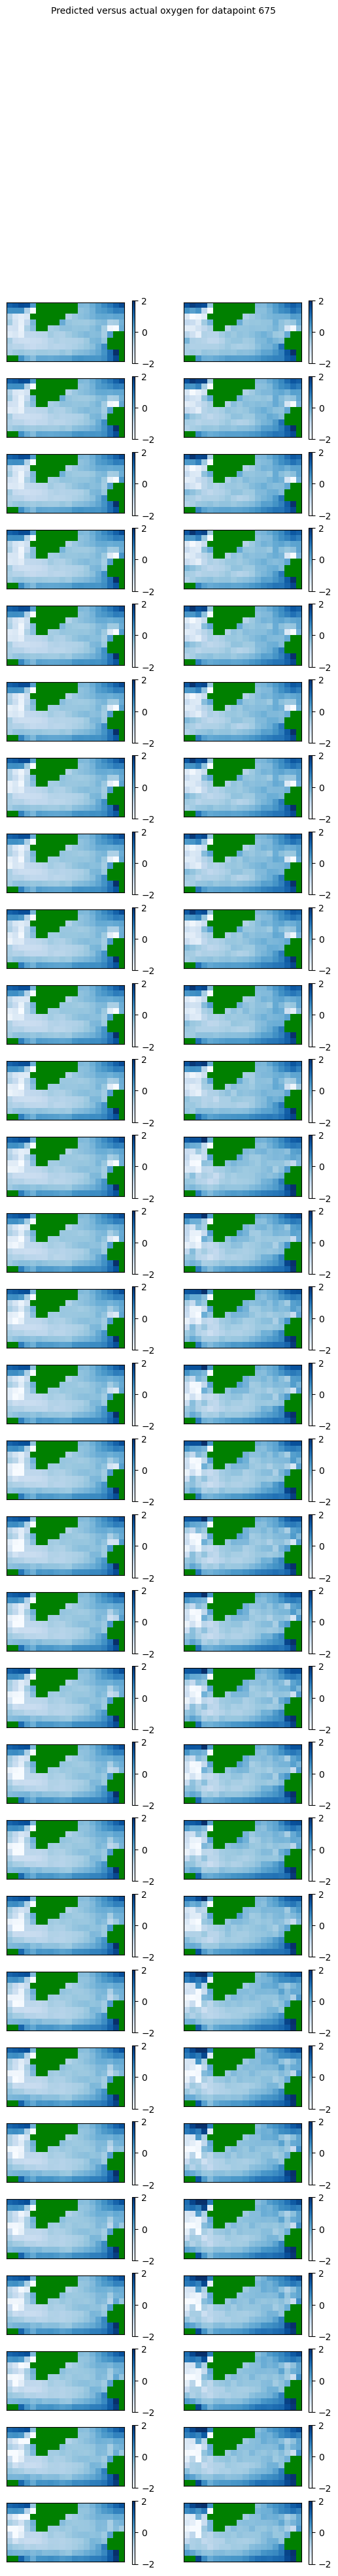

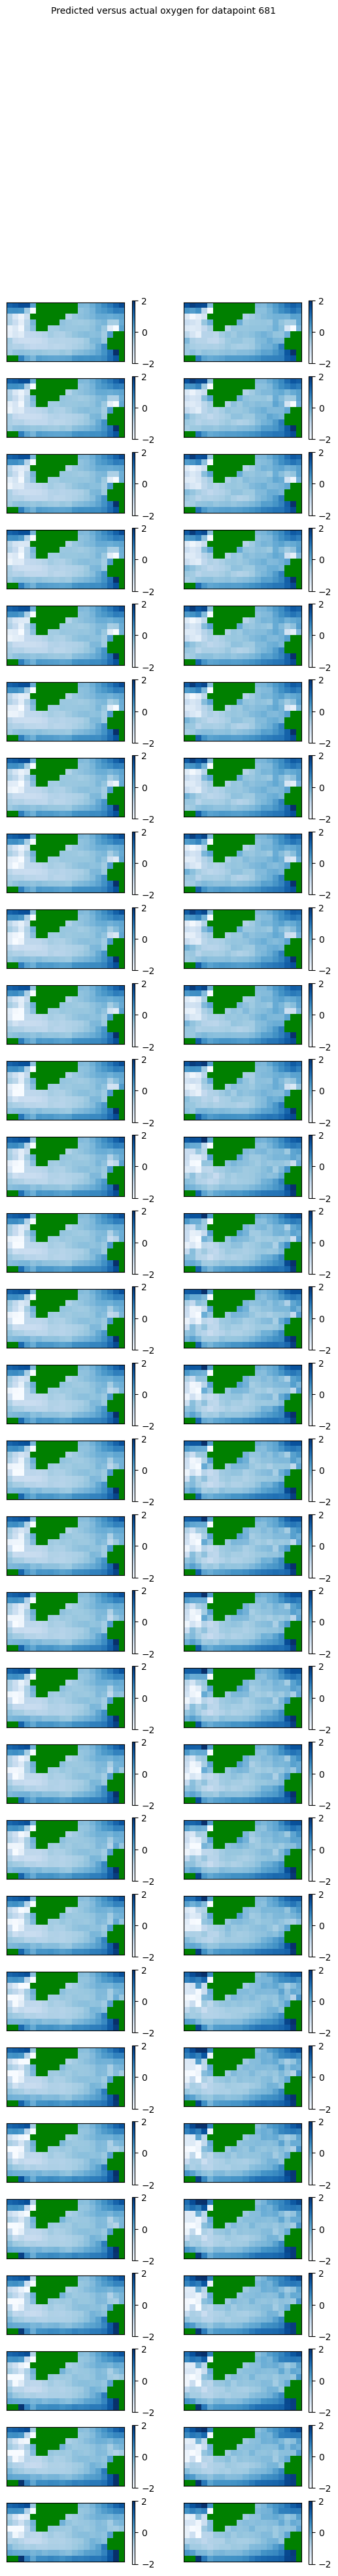

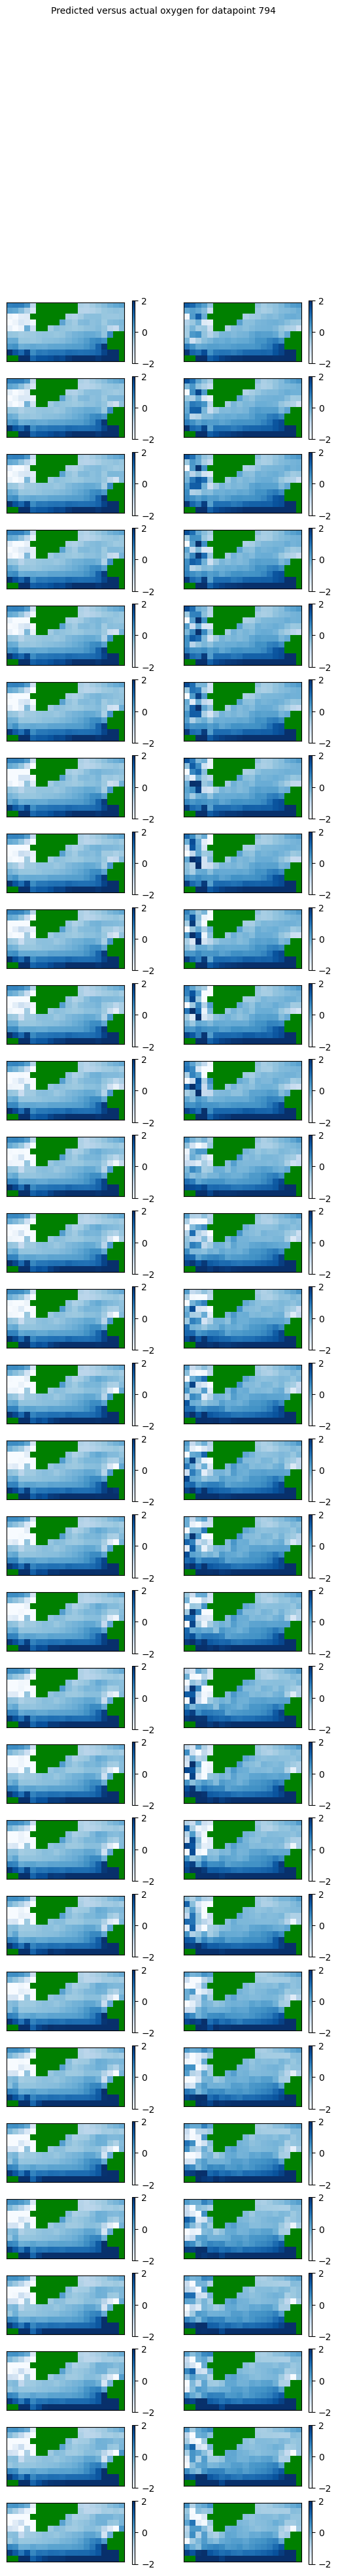

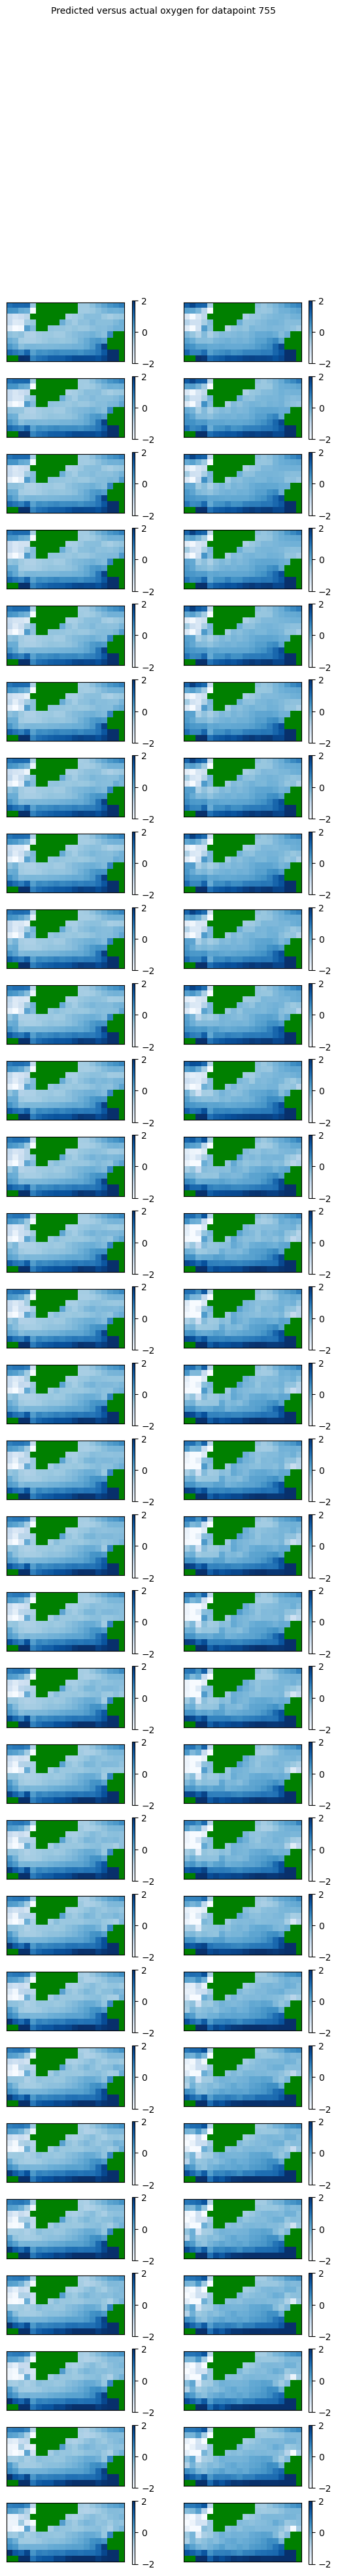

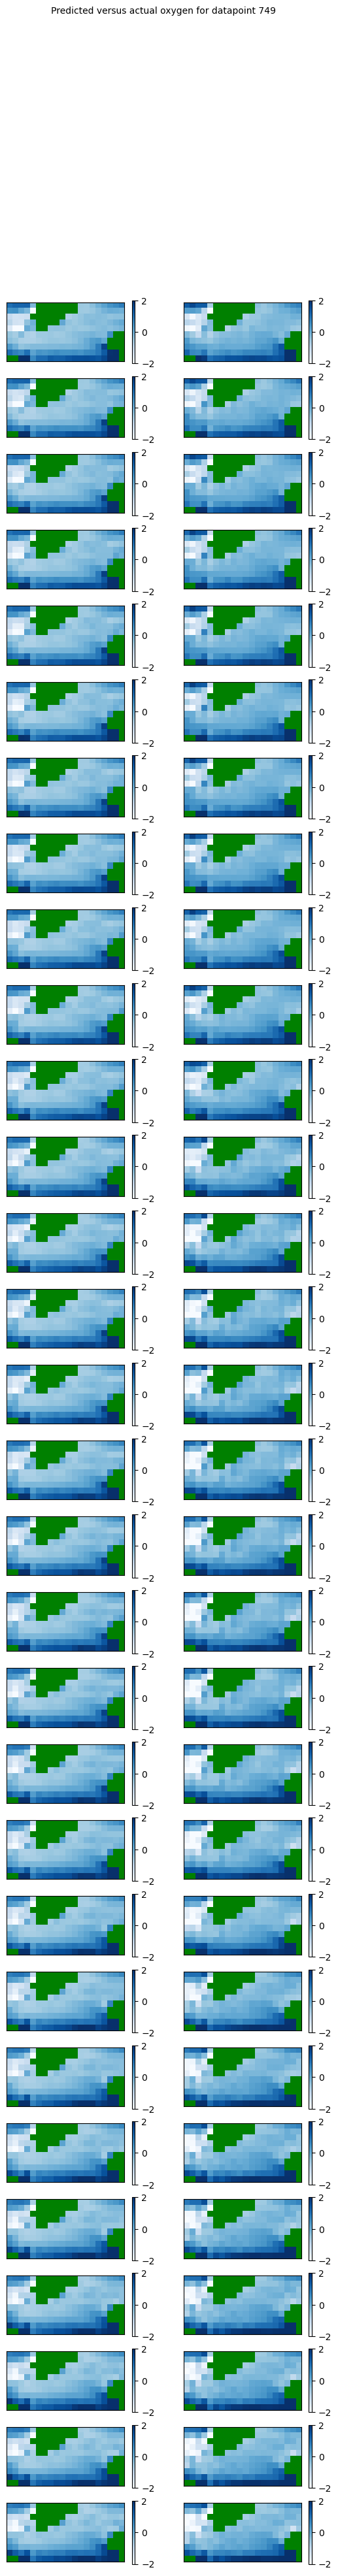

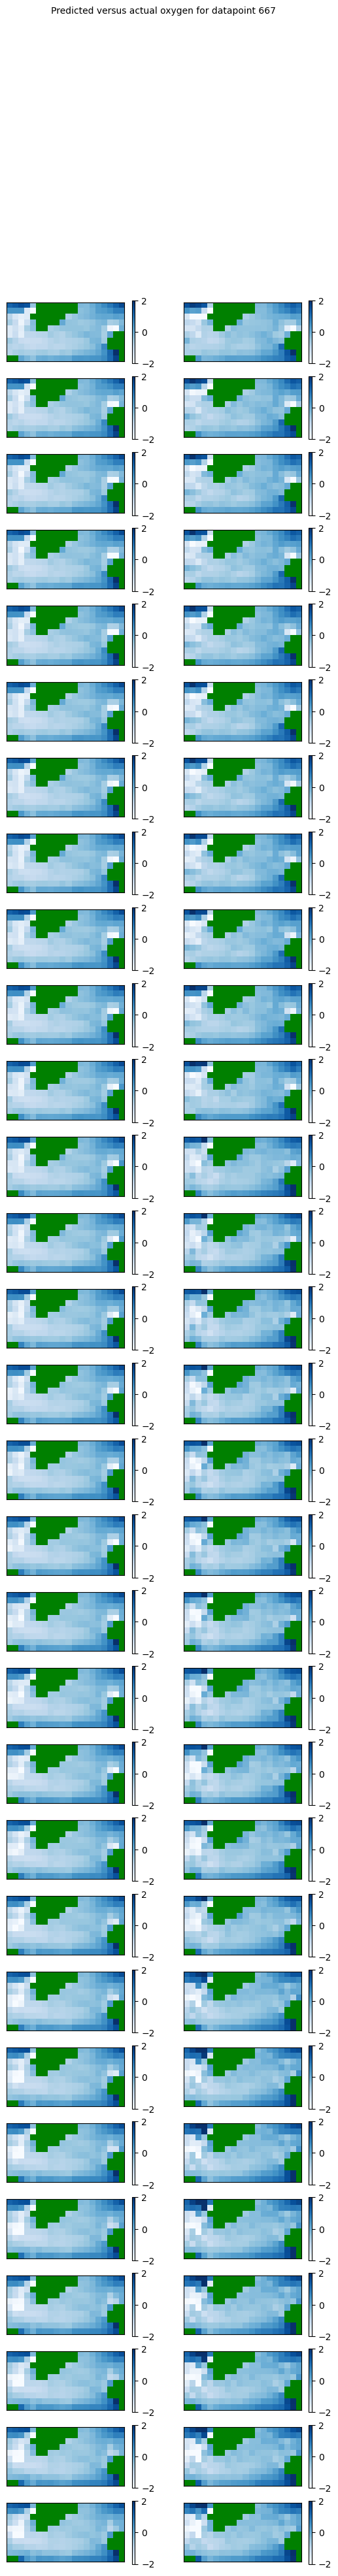

In [32]:
for i, ind in enumerate(sample_indices):
    y_pred_ = y_pred[i, 1, :, :, :]
    y_true_ = y_true[i, 1, :, :, :]

    fig, axes = plt.subplots(30,2)

    fig.set_figheight(45)
    
    fig.suptitle(f'Predicted versus actual oxygen for datapoint {ind}', fontsize=10)
    
    for j in range(30):
        axs = axes[j]
        axs[0].get_xaxis().set_ticks([])
        axs[0].get_yaxis().set_ticks([])
        axs[1].get_xaxis().set_ticks([])
        axs[1].get_yaxis().set_ticks([])
        t = axs[0].imshow(y_true_[j], cmap=cmap, vmin=-2, vmax=2)
        p = axs[1].imshow(y_pred_[j], cmap=cmap, vmin=-2, vmax=2)
        fig.colorbar(t, ax=axs[0], location='right')
        fig.colorbar(p, ax=axs[1], location='right')
    
    plt.savefig(f'graph_point_{ind}.pdf', format='pdf')
    plt.show()